<a href="https://colab.research.google.com/github/nyluje/RCP211_MIDI-VAE/blob/main/RCP211_Projet_2023_MIDI_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet RCP211: MIDI-VAE

## Import des librairies utilisées

Au moment de la réalisation du projet, l'environnement par défaut, du service Google Colab, utilisait les versions suivantes des librairies:


* `python version 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]`
* `numpy version 1.22.4`
* `torch version 2.0.1+cu118`
* `torchmetrics version 0.11.4`
* `tqdm version 4.65.0`
* `matplotlib version 3.7.1`
* `gdown version 4.6.6`
* `pretty-midi version 0.2.10`

In [1]:
#@title ###Import des packages non installés par défaut sur l'environnement

!sudo apt install -y -qq fluidsynth
!pip install --quiet --upgrade pyfluidsynth
!pip install --quiet pretty_midi
!pip install --quiet torchmetrics

fluidsynth is already the newest version (2.1.1-2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [2]:
#@title ###Import des librairies utilisées

import sys
import os
import re
from IPython import display

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchmetrics
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import MulticlassAccuracy

from tqdm.notebook import trange, tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


#print(f'IPython version {IPython}')

import gdown
import pretty_midi
import fluidsynth

print(f'python version {sys.version}')
print(f'numpy version {np.__version__}')
print(f'torch version {torch.__version__}')
print(f'torchmetrics version {torchmetrics.__version__}')
print(f'tqdm version {sys.modules.__getitem__("tqdm").version.__version__}')
print(f'matplotlib version {matplotlib.__version__}')
print(f'gdown version {gdown.__version__}')
print(f'pretty-midi version {pretty_midi.__version__}')


python version 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
numpy version 1.22.4
torch version 2.0.1+cu118
torchmetrics version 0.11.4
tqdm version 4.65.0
matplotlib version 3.7.1
gdown version 4.6.6
pretty-midi version 0.2.10


## Import du dataset et outils du projet de référence

Le jeu de données est importée à partir du [lien partagé sur  projet git](https://github.com/brunnergino/MIDI-VAE) par Brunner et al. (2019).

Les données sont nettoyées :
- Les données renvoyant des erreurs avec la fonction `load_rolls()` de Brunner et al. (2019) sont supprimées;
- Et les données, dont le tenseur produit par `load_rolls()` est inférieur à une longueur minimum de 40, sont supprimées.

Ajout de nouveau chemin python, pour utiliser les outils du projet de référence :
- Afin d'utiliser les classes python importées du projet de Brunner et al. (2019), leur chemin est ajouté dans la variable d'environnement.
- La fonction `load_rolls()` réduit, un fichier MIDI, aux caractéristiques minimums pour l'entraînement du modèle MIDI-VAE. Celle-ci est importée pour être utilisée par la suite.

Un model pré-entrainé `checkpoint.pt`, réalisé à la conception de ce projet, est également importé, pour ne pas démarrer l'entrainement du modèle de zéro.

In [3]:
#@title ###Import et nettoyage du dataset

%cd /content
!rm -r ./sample_data/MIDI-VAE_PaperData
url = 'https://drive.google.com/u/0/uc?id=1OpHNPENwLn1LIQiUb1BmyYYcz1xA41b-&export=download'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)
!unzip -q {output} -d ./sample_data
!rm -r ./sample_data/__MACOSX
!rm -r ./dataset.zip

#suppresion de chanson renvoyant une erreur avec la fonction load_rolls
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Dan_Fogelberg_-_Leader_of_the_Band.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/David_Bowie_-_Lazarus.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Billy_Joel_-_Movin'_Out.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Billy_Joel_-_Pressure.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Brian_McKnight_-_On_The_Down_Low.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Celine_Dion_-_That's_the_Way_It_Is.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Jackson_5_-_Dancing_Machine.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Jackson_5_-_I'll_Be_There.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Jackson_5_-_I_Want_You_Back.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Jackson_5_-_Never_Can_Say_Goodbye.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Lenny_Kravitz_-_I_Belong_to_You.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Marc_Anthony_-_Vivir_lo_Nuestro.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Third_Eye_Blind_-_Semi_Charmed_Life.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/a_taste_of_honey_jc2.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/maiden_voyage-HHancock_bg.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/on_the_sunny_side_of_the_street_rw.mid"

#supression pour longueur minimum de 40 du tenseur produit par la fonction loadroll
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/B'Witched_-_Blame_It_On_The_Weatherman.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Backstreet_Boys_-_I_Need_You_Tonight.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Bill_Withers_-_Aint_No_Sunshine.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Blessed_Union_Of_Souls_-_I_Believe.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Boyzone_-_Going_Gets_Tough.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Boyzone_-_I_Love_The_Way_You_Love_Me.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Britney_Spears_-_Britney_Spears_Medley.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Carly_Simon_-_Nobody_Does_it_Better.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Enya_-_Bard_Dance.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Geri_Halliwell_-_Look_At_Me.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Godspell_-_Day_by_Day.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/James_Taylor_-_Handyman.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Lionel_Richie_-_Three_Times_A_Lady.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Lionel_Richie_-_Truly.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Mandy_Moore_-_Candy.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/N_Sync_-_Everything_I_Own.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Neil_Diamond_-_September_Morning.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Olivia_Newton-John_-_Summer_Nights.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Paul_McCartney_-_Live_and_Let_Die.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Robyn_-_Show_Me_Love.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Seals_and_Crofts_-_Ill_Play_For_You.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Simon_and_Garfunkel_-_I_Am_A_Rock.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/TLC_-_Dear_Lie.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/The_Carpenters_-_Hurting_Each_Other.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/The_Commodores_-_Three_Times_A_Lady.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/The_Corrs_-_Along_With_the_Girls.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/The_Cowsills_-_Hair.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/The_Toys_-_A_Lover's_Concerto.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Tori_Amos_-_Josephine.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/Vangelis_-_Prelude.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/wonderland_by_night_dc.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Pop/you_will_be_my_music-frank-sinatra-kar_bpj.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/aint_misbehavin_rj.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/come_rain_or_come_shine-woody_gw.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/forgotten_dreams_gp.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/gentle_rain_luiz_bonfa_mw.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/i_gotta_right_to_sing_the_blues_hh.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/in_the_still_of_the_night-cp_dr.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/invitation_dwb.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/rum_n_coca_cola-andrews-sisters1945_ab.mid"
!rm "/content/sample_data/MIDI-VAE_PaperData/Jazz/two_sleepy_people_eh3.mid"






/content


Downloading...
From: https://drive.google.com/u/0/uc?id=1OpHNPENwLn1LIQiUb1BmyYYcz1xA41b-&export=download
To: /content/dataset.zip
100%|██████████| 32.4M/32.4M [00:00<00:00, 112MB/s] 


In [4]:
#@title ###Import du projet de référence

!rm -r ./MIDI-VAE
!git clone https://github.com/brunnergino/MIDI-VAE
!rm -r ./pickles
!sed -i 's/data\/original\//sample_data\/MIDI-VAE_PaperData\//g' ./MIDI-VAE/settings.py
!sed -i "s/'style1',\ 'style2'/'Jazz',\ 'Pop'/g" ./MIDI-VAE/settings.py

for i in ['/content/MIDI-VAE']:
  directory_path = os.path.abspath(os.path.join(i))
  if directory_path not in sys.path:
      sys.path.append(directory_path)
from import_midi import load_rolls as load_rolls

Cloning into 'MIDI-VAE'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 66 (delta 22), reused 59 (delta 20), pack-reused 1
Unpacking objects: 100% (66/66), 121.10 MiB | 8.54 MiB/s, done.
Updating files: 100% (40/40), done.


/content/MIDI-VAE/midi_functions.py:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  hold_this_note = note in notes and (i)% SMALLEST_NOTE is not 0


In [5]:
#@title ###Import du point de sauvegarde
!git clone https://github.com/nyluje/RCP211_MIDI-VAE
!cp -r ./RCP211_MIDI-VAE/checkpoint.pt ./
!rm -r ./RCP211_MIDI-VAE

Cloning into 'RCP211_MIDI-VAE'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), 13.32 MiB | 7.04 MiB/s, done.


## Paramètrage du device
Si un processeur carte graphique est disponible, il est paramétrés dans la variable device.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is ",device)

Device is  cuda


## Préparation du jeu de données

### Nombe de classes

Le nombre de classes gérables par le modèle est mis en paramètre. Pour être utilisable, les noms de ces paramètres doivent être cohérents avec la strucuration du jeu de données. Les noms utilisés reflètent les dénominations des répertoires de classement des données, représentées par chacune des classes. Dans le projet seules deux classes sont utilisées: "Pop" et "Jazz".

`LABELS_CLASSES` est en correspondance avec le jeu de données importées, divisé entre deux classes.


In [7]:
#@title ####Formulaire de configuration:
LABELS_CLASSES=["Pop","Jazz"] #@param

### Fonction de transformation
La classe `MidiTransform` est utilisée pour formater les données en des tenseurs aplatis en une seule dimension, consommables par le modèle:
- Le paramètre `SONG_MAX_LENGTH` correspond à la longueur conservée de la chanson. Pour limiter la taille du modèle en dessous de 25Mo (le maximum déposable sur le service GitHub, utilisé pour jouer le rôle de stockage de point de sauvegarde -Cf. la partie dédié au modèle), la longueur est limitée à 10 ;
- `PITCH_EXPECTED_SHAPE` et `INSTR_EXPECTED_SHAPE` utilisent des dimensions (`[64,61]` et `[4,16]`) pour cadrer aux prérequis de la fonction `load_rolls()` de Brunner et al. (2019).

In [8]:
#@title ####Formulaire de configuration:
SONG_MAX_LENGTH = 10 #@param
PITCH_EXPECTED_SHAPE = [64,61] #@param
INST_EXPECTED_SHAPE= [4,16] #@param


In [9]:
#@title #### Classe MidiTransform

class MidiTransform():
  def __init__(self,song_max_length=SONG_MAX_LENGTH,
               p_expected_shape=PITCH_EXPECTED_SHAPE,
               inst_expected_shape=INST_EXPECTED_SHAPE):
    self.song_max_length=song_max_length
    self.p_expected_shape=p_expected_shape
    self.inst_expected_shape=inst_expected_shape

  def __call__(self, X, Y, Inst, Tempo, V, D):
    assert(np.array_equal(X,Y))
    assert(len(X[0])==len(V[0]))
    assert(X.shape[1]==self.p_expected_shape[0] and X.shape[2]==self.p_expected_shape[1])
    assert(V.shape[1]==self.p_expected_shape[0])
    assert(Inst.shape[0]==self.inst_expected_shape[0] and Inst.shape[1]==self.inst_expected_shape[1])


    P=np.reshape(X[:self.song_max_length], (self.song_max_length*self.p_expected_shape[0]*self.p_expected_shape[1]))
    Inst= np.reshape(Inst, (self.inst_expected_shape[0]*self.inst_expected_shape[1]))
    V=np.reshape(V[:self.song_max_length], (self.song_max_length*self.p_expected_shape[0]))

    return P, Inst, V

### Jeu de donnée
Une classe `MidiDataset`, héritant de la classe `Dataset` de la librairie pytorch, est créée. Elle permet de convertir les fichiers MIDI en données d'entraînement et de validation pour le modèle.
La redéfinition de la fonction `__getitem__()` utilise la fonction `load_rolls()`, évoquée plus haut, et la classe `MidiTransform` pour retourner les trois jeux de données utilisés pour entraîner le modèle :
- *Pitch roll* ;
- *Instrument roll* ;
- Et *Velocity roll*.

In [10]:
#@title #### Class MidiDataset

class MidiDataset(Dataset):
    """ Midi files Dataset """

    def __init__(self, file_dir="/content/sample_data/MIDI-VAE_PaperData/", labels=[0,1],transforms=MidiTransform()):
        """
        Args:
            file_dir (string): répertoire avec les fichiers par sous répetoire selon classe.
            labels (array(string)): classe de musique.
            transforms (optional): Changes on the data.
        """
        self.file_dir = file_dir
        self.transforms = transforms

        self.midi_filenames=np.array([], dtype=str)
        self.labels=np.array([], dtype=np.int16)
        for label_id in labels:
          midis_to_add = os.listdir(os.path.join(file_dir, LABELS_CLASSES[label_id]))
          midis_to_add.sort()
          filenames_to_add = np.array([midi for midi in midis_to_add])
          labels_to_add = np.full(filenames_to_add.shape[0],label_id,dtype=np.int16)
          self.midi_filenames=  np.append(self.midi_filenames,filenames_to_add)
          self.labels = np.append(self.labels,labels_to_add)

    def __len__(self):
        assert(len(self.midi_filenames)==len(self.labels))
        return len(self.midi_filenames)

    def __getitem__(self, idx):
        midi_filename = self.midi_filenames[idx]
        midi_label = self.labels[idx]
        X, Y, Inst, Tempo, V, D=load_rolls(self.file_dir+"/"+LABELS_CLASSES[midi_label]+"/",midi_filename)
        if self.transforms:
          P, Inst, V= self.transforms(X, Y, Inst, Tempo, V, D)
        return P, Inst, V, midi_label, midi_filename

### Séparation en deux jeux de données et préparation du dataloader
Le dataset est séparé entre un jeu de données d'entraînement et un jeu de données de validation.

La classe Dataloader de pytorch est ensuite utilisée pour grouper les données en batchs, utilisables pour l'entraînement du modèle.

In [11]:
generator1 = torch.Generator().manual_seed(78)
train_set, val_set = torch.utils.data.random_split(MidiDataset(), [0.9, 0.1],generator1)


In [12]:
train_dataloader= DataLoader(train_set, batch_size=8,shuffle=True)
test_dataloader= DataLoader(val_set, batch_size=8,shuffle=True)

## Création et implémentation de MIDI-VAE
Le découpage est le suivant:
- Liste des paramètres ;
- Détail des différents composants de l'autoencodeur MIDI-VAE ;
- Fonction de perte du modèle ;
- Fonction d'entrainement ;
- Représentation des résultats.

### Liste des paramètres

Les paramètres utilisés sont les suivants:

- `CHECKPOINT_PATH`: L'entraînement du modèle prend du temps. Brunner et al. (2019) décrivent 400 epochs sur 48h pour un modèle qui converge. Pour cela un système de checkpoint a été mis en place pour sauver l'état et pouvoir reprendre, plus tard, en cas de déconnexion du service de calcul.

- `LATENT_DIMENSION`: La dimension de l'espace latent a été réduite à 32. Brunner et al. (2019) ont utilisé un espace latent d'une dimension 256. Cependant, le nombre de paramètres, au sein du modèle, engendrés par une telle dimension, donnait un modèle trop gourmand en espace de stockage. Le modèle intermédiaire d'entrainement n'aurait pas pu être stocké via le service GitHub.

- Les valeurs des hyperparamètres de la fonction de perte suivent les recommandations l'article de Brunner et al. (2019):
 - `LAMBDA_PITCH` = 1
 - `LAMBDA_INSTR` = 1
 - `LAMBDA_VELO` = 0.1
 - `LAMBDA_STYLE` = 0.1
 - `BETA_DKL` = 0.1

- `STD_PARAM_TRICK` : Une particularité décrite dans l'article est l'utilisation d'une variance $\sigma_\epsilon$ d'une valeur de 0.01 sur la loi normale utilisée dans le *reparametrization trick*.

In [13]:
#@title ####Formulaire de configuration { form-width: "40%" }

CHECKPOINT_PATH="/content/checkpoint.pt" #@param
LATENT_DIMENSION=32 #@param
LAMBDA_PITCH = 1 #@param
LAMBDA_INSTR = 1 #@param
LAMBDA_VELO = 0.1 #@param
LAMBDA_STYLE = 0.1 #@param
BETA_DKL = 0.1 #@param
STD_PARAM_TRICK = 0.01 #@param

### Encodeur

L'encodeur est composé de trois branches de type GRU en entrée pour gérer :
- *Pitch roll* (GRU 2 couches cachées) ;
- *Instrument roll* (GRU 1 couche cachée) ;
- et *Velocity roll* (GRU 1 couche cachée) ;
- Chacune des branches produit des sorties sur lesquelles une activation `tanh()` est appliquée. L'article spécifie un meilleur retour d'expérience, avec cette fonction d'activation, plutôt qu'une `sigmoid()`, pour linéariser les sorties ;
- La dimension en sortie de chacune des 3 branches (*Pitch roll*, *Instrument roll* et *Velocity roll*) correspond à une dimension proportionnelle à la taille de l'espace latent. Les proportions ont été décidé arbitrairement en estimant l'importance des vecteurs applatis:
 - *Pitch roll* 23 sur 32 ;
 - *Instrument roll* 1 sur 32 ;
 - et *Velocity roll* 8 sur 32.

Les sorties des 3 branches sont ensuites regroupées en un seul vecteur. A partir de ce vecteur trois sorties sont produites:
- Le résultat groupé (ce vecteur sera utilisé par la couche de classification `StyleClassifier`) ;
- Et deux sorties $\mu$ et $\sigma$ représentant la loi normale de l'espace latent à respecter dans le VAE.

In [14]:
#@title ####Classes de l'encodeur

class EncoderLayer(nn.Module):
  def __init__(self,input_roll_size,hidden,num_layers,out_features,batch_first=True):
    super(EncoderLayer,self).__init__()
    self.gru_layer_1=nn.GRU(input_size=input_roll_size,hidden_size=hidden,num_layers=num_layers,batch_first=batch_first)
    self.dense=nn.Linear(in_features=hidden, out_features=out_features)
  def forward(self, x):
    res,_ = self.gru_layer_1(x)
    res = F.tanh(self.dense(res)) #comme conseillé dans le papier tanh est appliqué pour linéariser les sorties
    return res

class Encoders(nn.Module):
  def __init__(self,latent_dimension=LATENT_DIMENSION,
               pitch_roll_size=SONG_MAX_LENGTH*PITCH_EXPECTED_SHAPE[0]*PITCH_EXPECTED_SHAPE[1],
               intrument_roll_size=INST_EXPECTED_SHAPE[0]*INST_EXPECTED_SHAPE[1],
               velocity_roll_size=SONG_MAX_LENGTH*PITCH_EXPECTED_SHAPE[0]):
    super(Encoders,self).__init__()
    assert(latent_dimension%32==0)
    self.latent_dimension=latent_dimension

    self.pitch_encoder= EncoderLayer(input_roll_size=pitch_roll_size,hidden=int((self.latent_dimension/32)*23),num_layers=2,out_features=int((self.latent_dimension/32)*23))
    self.instrument_encoder= EncoderLayer(input_roll_size=intrument_roll_size,hidden=int(self.latent_dimension/32),num_layers=1,out_features=int(self.latent_dimension/32))
    self.velocity_encoder= EncoderLayer(input_roll_size=velocity_roll_size,hidden=int((self.latent_dimension/32)*8),num_layers=1,out_features=int((self.latent_dimension/32)*8))
    self.group_layers=nn.Linear(in_features=self.latent_dimension, out_features=self.latent_dimension)
    self.lin_mu=nn.Linear(in_features=self.latent_dimension, out_features=self.latent_dimension)
    self.lin_sigma=nn.Linear(in_features=self.latent_dimension, out_features=self.latent_dimension)

  def forward(self, pitch_roll, instrument_roll, velocity_roll):
    pitch = self.pitch_encoder(pitch_roll)
    inst = self.instrument_encoder(instrument_roll)
    velo = self.velocity_encoder(velocity_roll)
    group = torch.cat([pitch, inst, velo], dim=1)
    group = self.group_layers(group)
    lin_mu = self.lin_mu(group)
    lin_sigma = self.lin_mu(group)
    return lin_mu,lin_sigma, group


### Décodeur

L'opération du décodeur est inverse à celle de l'encodeur.

Le vecteur d'entrée est l'association de l'espace latent et du vecteur de classe. Cette entrée passe par une couche complétement connectée pour reformater à la taille de l'espace latent.

Ceci est ensuite divisé en trois branches: spécialisées dans la reconstruction des *rolls*. La sortie produite respecte la taille d'origine des données entrées dans l'encodeur. Les trois branches, utilisant des couches de type GRU, sont en mirroir des branches utilisées dans l'encodeur:
* *Pitch roll* (GRU 2 couches cachées),
* *Instrument roll* (GRU 1 couche cachée),
* et *Velocity roll* (GRU 1 couche cachée).

In [15]:
#@title ####Classe du décodeur
class DecoderLayer(nn.Module):
  def __init__(self,input_dense,num_layers,output_roll_size,batch_first=True):
    super(DecoderLayer,self).__init__()
    self.dense=nn.Linear(in_features=input_dense, out_features=input_dense)
    self.gru_layer_1=nn.GRU(input_size=input_dense,hidden_size=input_dense,num_layers=num_layers,batch_first=batch_first)
    self.exit_layer=nn.Linear(in_features=input_dense, out_features=output_roll_size)
  def forward(self, x):
    res = F.tanh(self.dense(x))
    res,_ = self.gru_layer_1(res)
    res = F.tanh(self.exit_layer(res))
    return res


class Decoders(nn.Module):
  def __init__(self,latent_dimension=LATENT_DIMENSION,
               class_dim=len(LABELS_CLASSES),
               pitch_roll_size=SONG_MAX_LENGTH*PITCH_EXPECTED_SHAPE[0]*PITCH_EXPECTED_SHAPE[1],
               intrument_roll_size=INST_EXPECTED_SHAPE[0]*INST_EXPECTED_SHAPE[1],
               velocity_roll_size=SONG_MAX_LENGTH*PITCH_EXPECTED_SHAPE[0]):
    super(Decoders,self).__init__()
    self.latent_dimension=latent_dimension
    self.in_features=latent_dimension+class_dim
    self.dec_lin=nn.Linear(in_features=self.in_features,out_features=int(self.latent_dimension))
    self.pitch_dec=DecoderLayer(input_dense=int((self.latent_dimension/32)*23),num_layers=2,output_roll_size=pitch_roll_size)
    self.instrument_dec=DecoderLayer(input_dense=int(self.latent_dimension/32),num_layers=1,output_roll_size=intrument_roll_size)
    self.velocity_dec=DecoderLayer(input_dense=int((self.latent_dimension/32)*8),num_layers=1,output_roll_size=velocity_roll_size)

  def forward(self,latent_vector,target_class):
    latent_vector=torch.cat((latent_vector,target_class),1)
    latent_vector = F.tanh(self.dec_lin(latent_vector))
    ungroup_pitch, ungroup_instrument, ungroup_velocity = torch.split(
        latent_vector,[int((self.latent_dimension/32)*23),
        int(self.latent_dimension/32),
        int((self.latent_dimension/32)*8)], dim=1)
    pitch_pred=self.pitch_dec(ungroup_pitch)
    instrument_pred=self.instrument_dec(ungroup_instrument)
    velocity_pred = self.velocity_dec(ungroup_velocity)
    return pitch_pred,instrument_pred,velocity_pred


### Classifieur de style

Un classifieur de style, utilise la sortie de l'espace latent pour produire un vecteur logit, de classement probabiliste, sur lequel une fonction softmax est appliquée.

In [16]:
#@title ####Classe du classifieur de style

class StyleClassifier(nn.Module):
  #def __init__(self, input=256, number_of_style=2):
  def __init__(self, input=LATENT_DIMENSION, number_of_style=len(LABELS_CLASSES)):
    super(StyleClassifier,self).__init__()
    self.lin=nn.Linear(in_features=input,out_features=number_of_style)

  def forward(self,x):
    return F.softmax(self.lin(x),dim=1)

### Auto-encodeur variationnel

Les couches expliquées précédement sont associées:
- La couche encodeur est en entrée et produit 3 sorties:
 - Vecteur non modifié ;
   - Celui-ci est utilisé par la couche de classification de style ;
 - Vecteur moyenne ;
 - Vecteur variance.
- Les vecteurs de moyenne et de variance de cette couche encodeur sont passés dans la fonction `latent_sample()`, reprise du TP8, permettant l'application du *parametrization trick*. Le résultat de cette transformation est envoyé dans le décodeur (avec le vecteur obtenu par la couche de classification de style). Le décodeur produit une reconstruction des trois *rolls*.

In [17]:
#@title ####Classe auto-encodeur variationnel

class VariationalAutocencoder(nn.Module):
  def __init__(self, latent_dimension=LATENT_DIMENSION, std_param_trick=1):
    super(VariationalAutocencoder,self).__init__()
    self.latent_dimension=latent_dimension
    self.std_param_trick=std_param_trick
    self.enc=Encoders()
    self.style_classifier = StyleClassifier()
    self.dec=Decoders()
  def forward(self, pitch_roll, instrument_roll, velocity_roll, song_class):
    latent_mu, latent_logvar, raw_result = self.enc(pitch_roll, instrument_roll, velocity_roll)
    style_pred = self.style_classifier(raw_result)
    pitch_pred, intrument_pred, velocity_pred = self.dec(self.latent_sample(latent_mu,latent_logvar),song_class)
    return pitch_pred, intrument_pred, velocity_pred, style_pred, latent_mu, latent_logvar

  def latent_sample(self, mu, logvar): #repris du TP8_CVAE_PixelCNN
    if self.training:
      std = logvar.mul(0.5).exp_()*self.std_param_trick
      eps = torch.empty_like(std).normal_()
      return eps.mul(std).add_(mu)
    else:
      return mu

### Fonction de perte

Un fonction de perte, `midivae_loss()`, similaire à celle décrite dans l'article est utlisée : $\mathcal{L}_{tot}=\lambda_{p}H(P,\hat{P}) + \lambda_{i}H(I,\hat{I})+\lambda_{v}ME(V,\hat{V})+\lambda_{s}H(S,\hat{S})-\beta D_{KL}(q||p) $

Avec: $H(\cdot,\cdot)$, $MSE(\cdot,\cdot)$, et $D_{KL}(\cdot,\cdot)$ réprésentant respectivement: L'entropie croisée, l'erreur quadratique moyenne, et la divergence de KL.

Les poids $\lambda_{p}$, $\lambda_{i}$, $\lambda_{v}$, $\lambda_{s}$, $\beta$, correspondent aux poids des hyperparamètres listés précédement, pondérant les pertes: du *pitch*, d'*instrument*, de *velocity*, du style, et la divergence entre l'espace latent et la loi normale $\mathcal{N}(\mu,\sigma)$.

In [18]:
#@title ####Fonction midivae_loss

def midivae_loss(lambda_pitch, pred_pitch, target_pitch,
                 lambda_instr, pred_instr, target_instr,
                 lambda_velo, pred_velo, target_velo,
                 lambda_style, pred_style, target_style,
                 beta_dkl, mu ,logvar):
  pitch_loss = F.cross_entropy(pred_pitch,target_pitch)
  instr_loss = F.cross_entropy(pred_instr,target_instr)
  velo_loss = F.mse_loss(pred_velo,target_velo)
  style_loss = F.binary_cross_entropy_with_logits(pred_style, target_style.float())
  kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #repris du TP8
  total_loss = lambda_pitch*pitch_loss + lambda_instr*instr_loss + lambda_velo*velo_loss + lambda_style*style_loss + beta_dkl*kl_divergence
  return total_loss, pitch_loss, instr_loss, velo_loss, style_loss, kl_divergence

###Entrainement du modèle

L'entrainement du modèle utilise une suite d'instructions proche de celles utilisées dans les différents TP. Avec la particularité du checkpoint pour reprendre de l'état pré-entrainé enregistré après chaque epoch.

La valeur 88 du paramètre `epochs` passée dans l'utilisation de la fonction d'entrainement `vaemidi_trainer`, sert à limiter l'exécution de l'apprentissage à une *epoch* à partir de l'état du modèle récupéré via le fichier `checkpoint.pt` représentatif des 87 entraînements précédents.

In [19]:
#@title ####Fonction vaemidi_trainer

def vaemidi_trainer(vae, train_dataset, epochs=10, learning_rate=1e-3, batch_size=128, device=device, checkpoint_path=CHECKPOINT_PATH):
  weight_decay = 1e-5
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  avg_pitch_loss_log, avg_instr_loss_log, avg_velo_loss_log, avg_style_loss_log, avg_total_loss_log, epoch=[],[],[],[],[], None

  optimizer = torch.optim.Adam(params=vae.parameters(),lr=learning_rate,weight_decay=weight_decay)
  vae=vae.to(device)
  if os.path.exists(checkpoint_path):
    map_location=torch.device('cpu') if torch.cuda.is_available() is False else torch.device('cuda')
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
    vae.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    avg_pitch_loss_log, avg_instr_loss_log, avg_velo_loss_log, avg_style_loss_log, avg_total_loss_log = checkpoint['avg_pitch_loss_log'], checkpoint['avg_instr_loss_log'], checkpoint['avg_velo_loss_log'], checkpoint['avg_style_loss_log'], checkpoint['avg_total_loss_log']

  vae.train()
  t = trange(0 if epoch is None else epoch, epochs + 1, desc="Entraînement du modèle")


  for epoch in t:
    avg_total_loss, avg_pitch_loss, avg_instr_loss, avg_velo_loss, avg_style_loss = 0, 0, 0, 0, 0
    for i,  (pitch_target, instr_target, velo_target, midi_label, midi_filename) in enumerate(train_dataloader):
      pitch_target=pitch_target.type(torch.float32).to(device)
      instr_target=instr_target.type(torch.float32).to(device)
      velo_target=velo_target.type(torch.float32).to(device)
      labels = F.one_hot(midi_label.long(), num_classes=2).to(device)
      pitch_pred, intrument_pred, velocity_pred, style_pred, latent_mu,latent_logvar=vae(pitch_target,instr_target,velo_target,labels)


      #calcul de la perte
      total_loss, pitch_loss, instr_loss, velo_loss, style_loss, kl_divergence = midivae_loss(
          LAMBDA_PITCH,pitch_pred,pitch_target,LAMBDA_INSTR,intrument_pred,instr_target,LAMBDA_VELO,velocity_pred,velo_target,LAMBDA_STYLE,style_pred,labels,BETA_DKL,latent_mu,latent_logvar)

      #retropropagation du gradient
      optimizer.zero_grad() #met les gradient des tenseur à optimiser à 0
      total_loss.backward() #
      optimizer.step() #

      avg_pitch_loss += pitch_loss.item()
      avg_instr_loss += instr_loss.item()
      avg_velo_loss += velo_loss.item()
      avg_style_loss += style_loss.item()
      avg_total_loss += total_loss.item()

    avg_pitch_loss /= len(train_dataloader)
    avg_instr_loss /= len(train_dataloader)
    avg_velo_loss /= len(train_dataloader)
    avg_style_loss /= len(train_dataloader)
    avg_total_loss /= len(train_dataloader)

    t.set_description(f"Epoch {epoch}: total loss = {avg_total_loss:.2f} ; pitch loss = {avg_pitch_loss:.2f} ; instrument loss = {avg_instr_loss:.2f} ; velocity loss = {avg_velo_loss:.2f} ; style loss = {avg_style_loss:.2f}")

    avg_pitch_loss_log.append(avg_pitch_loss)
    avg_instr_loss_log.append(avg_instr_loss)
    avg_velo_loss_log.append(avg_velo_loss)
    avg_style_loss_log.append(avg_style_loss)
    avg_total_loss_log.append(avg_total_loss)


    torch.save({ #sauvegarde du dernier état
      'epoch': epoch,
      'model_state_dict': vae.state_dict(),
      'avg_pitch_loss_log': avg_pitch_loss_log,'avg_instr_loss_log' : avg_instr_loss_log, 'avg_velo_loss_log':avg_velo_loss_log,'avg_style_loss_log':avg_style_loss_log, 'avg_total_loss_log':avg_total_loss_log
    }, checkpoint_path)

  return vae.to(device), avg_pitch_loss_log, avg_instr_loss_log, avg_velo_loss_log, avg_style_loss_log, avg_total_loss_log


In [20]:
####Entrainement du modèle
vae = VariationalAutocencoder(std_param_trick=STD_PARAM_TRICK)
vae, avg_pitch_loss_log, avg_instr_loss_log, avg_velo_loss_log, avg_style_loss_log, avg_total_loss_log = vaemidi_trainer(vae,train_set, epochs=88,batch_size=128)

Entraînement du modèle:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


### Représentation des résultats

- Sur les coubes de l'evolution de la perte lors de l'entraînenemnt, on constate que le modèle ne converge pas.
- Sur le calcul de précision moyen, les résultats reflètent l'inefficacité du modèle.





<Figure size 2000x2000 with 0 Axes>

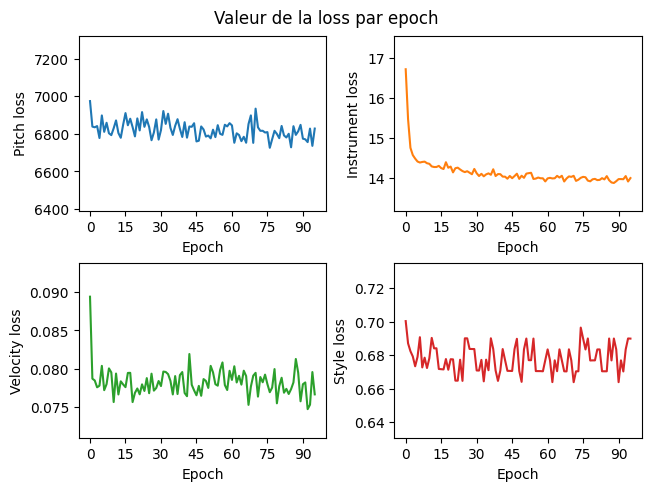

In [21]:
#@title ####Courbes d'évolution de la perte lors de l'entrainement


plt.figure(figsize=(20, 20))

#x = np.linspace(0, 2 * np.pi, len(avg_pitch_loss_log))
x = range(len(avg_pitch_loss_log))


fig, axs = plt.subplots(2, 2,constrained_layout = True)
axs[0, 0].plot(x, avg_pitch_loss_log, label="Pitch loss")
axs[0, 0].set_ylim(min(avg_pitch_loss_log)*0.95,max(avg_pitch_loss_log)*1.05)
axs[0, 0].set_ylabel('Pitch loss')
axs[0, 1].plot(x, avg_instr_loss_log, 'tab:orange', label="Instrument loss")
axs[0, 1].set_ylim(min(avg_instr_loss_log)*0.95,max(avg_instr_loss_log)*1.05)
axs[0, 1].set_ylabel('Instrument loss')
axs[1, 0].plot(x, avg_velo_loss_log, 'tab:green', label="Velocity loss")
axs[1, 0].set_ylim(min(avg_velo_loss_log)*0.95,max(avg_velo_loss_log)*1.05)
axs[1, 0].set_ylabel('Velocity loss')
axs[1, 1].plot(x, avg_style_loss_log, 'tab:red', label="Style loss")
axs[1, 1].set_ylim(min(avg_style_loss_log)*0.95,max(avg_style_loss_log)*1.05)
axs[1, 1].set_ylabel('Style loss')

for ax in axs.flat:
    ax.set(xlabel='Epoch')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.suptitle('Valeur de la loss par epoch')
plt.show()


In [22]:
#@title ####Evaluation de la précision
def accuracy_results(vae,dataloader):
  vae.eval()

  accuracy_pitch=[]
  accuracy_instr=[]
  accuracy_velo=[]
  accuracy_label=[]

  binary_accuracy=BinaryAccuracy()
  mul_class_accuracy=MulticlassAccuracy(num_classes=len(LABELS_CLASSES))
  for i,  (pitch_target, instr_target, velo_target, midi_label, midi_filename) in enumerate(test_dataloader):
    with torch.no_grad():
      pitch_target=pitch_target.type(torch.float32).to(device)
      instr_target=instr_target.type(torch.float32).to(device)
      velo_target=velo_target.type(torch.float32).to(device)
      labels = F.one_hot(midi_label.long(), num_classes=len(LABELS_CLASSES)).to(device)
      pitch_pred, intrument_pred, velocity_pred, style_pred, latent_mu, latent_logvar = vae(pitch_target, instr_target, velo_target, labels)
      accuracy_pitch.append(binary_accuracy(pitch_pred.to("cpu"),pitch_target.to("cpu")))
      accuracy_instr.append(binary_accuracy(intrument_pred.to("cpu"),instr_target.to("cpu")))
      accuracy_velo.append(F.mse_loss(velocity_pred.to("cpu"),velo_target.to("cpu")))
      accuracy_label.append(mul_class_accuracy(style_pred.to("cpu"),midi_label.to("cpu")))
  return np.array(accuracy_pitch).mean(),np.array(accuracy_instr).mean(),np.array(accuracy_velo).mean(),np.array(accuracy_label).mean()

accuracy_pitch,accuracy_instr,accuracy_velo,accuracy_lab=accuracy_results(vae,train_dataloader)
print(f"Avec le jeu d'entrainement: moyenne reconstruction pitch={accuracy_pitch:.2f}, moyenne reconstrution instrument={accuracy_instr:.2f},moyenne reconstruction velocité={accuracy_velo:.2f},moyenne étiquetage={accuracy_lab:.2f}")
accuracy_pitch,accuracy_instr,accuracy_velo,accuracy_lab=accuracy_results(vae,test_dataloader)
print(f"Avec le jeu de validation: moyenne reconstruction pitch={accuracy_pitch:.2f}, moyenne reconstrution instrument={accuracy_instr:.2f},moyenne reconstruction velocité={accuracy_velo:.2f},moyenne étiquetage={accuracy_lab:.2f}")

Avec le jeu d'entrainement: moyenne reconstruction pitch=0.96, moyenne reconstrution instrument=0.79,moyenne reconstruction velocité=0.08,moyenne étiquetage=0.50
Avec le jeu de validation: moyenne reconstruction pitch=0.96, moyenne reconstrution instrument=0.79,moyenne reconstruction velocité=0.08,moyenne étiquetage=0.50
